# 2. Baseline Prediction

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter

import numpy as np
import os
import pandas as pd

from sklearn.metrics import mean_squared_error
import scipy.stats

import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
CMIP6_ANOM_1M_FOLDER = 'datasets/CMIP6/CMIP6_regridded/anom_1m'
CMIP6_ONI_FOLDER = 'datasets/CMIP6/CMIP6_regridded/oni'
CMIP6_NINO34_FOLDER = 'datasets/CMIP6/CMIP6_regridded/nino34'

HadISST_ANOM_1M_FOLDER = 'datasets/HadISST/HadISST_regridded/anom_1m'
HadISST_ONI_FOLDER = 'datasets/HadISST/HadISST_regridded/oni'
HadISST_NINO34_FOLDER = 'datasets/HadISST/HadISST_regridded/nino34'


IMG_FOLDER = 'img/'

SAVE_PLOTS_TO_DISK = True

In [3]:
os.makedirs(IMG_FOLDER, exist_ok=True) 

## Define Functions

#### `find_file`

In [4]:
def find_file(directory, source_id):
    filenames = os.listdir(directory)

    # Iterate over files int the directory and return the first match
    for filename in filenames:
        if source_id in filename:
            filepath = os.path.join(directory, filename)
            return filename, filepath
    print(f"No file with source id {source_id} was found")
    return None 

In [5]:
find_file(CMIP6_ANOM_1M_FOLDER, "BCC-ESM1")

('CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc',
 'datasets/CMIP6/CMIP6_regridded/anom_1m/CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc')

#### `load_target_timeseries`

In [6]:
#### Load ONI or Nino34 timesereis ####
# inspired by CCAI AI for Climate science workshop - Forecasting the El Niño with Machine Learning
def load_target_timeseries(source_id, target, start_date, end_date, verbose):

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if target == "oni":
        target_folder = CMIP6_ONI_FOLDER
        target_var_name = 'oni'
    elif target == "nino34":
        target_folder = CMIP6_NINO34_FOLDER
        target_var_name = 'nino34'
    else:
        print(f"Unknown target {target}. Abort")
        return
    
    target_filename, target_filepath = find_file(target_folder, source_id)
    
    df = pd.read_csv(target_filepath, sep='\t', index_col=0) 
    df.index = pd.to_datetime(df.index)
    
    target_ts = df[target_var_name]
    target_ts = target_ts[start_date:end_date]
    
    if verbose: 
        print(f"\n• Search for `{source_id}` target file in {target_folder}")
        print(f"• Load {target_filename}", end=" ")
        print(f"({df.index[0].date()} to {df.index[-1].date()})")
        print(f"• Slice the time period from {start_date.date()} to {end_date.date()}")
        print(f"• The dimensions are: {target_ts.shape}: {target_ts.shape[0]} months, 1 target value per month\n")
    
    return target_ts.astype(np.float32)

## Load data

In [7]:
source_id = "MRI-ESM2-0"
# source_id = "MIROC6"
# source_id = "BCC-ESM1"
# source_id = "GISS-E2-1-G"

target = "nino34"

In [8]:
train_start_date = '1851-01-01'
train_end_date = '1970-12-31'

val_start_date = '1976-01-01'
# val_start_date = '1988-01-01'
val_end_date =   '1990-12-31'

test_start_date = '1996-01-01'
test_end_date =   '2010-12-31'

print(f"Train start and end dates: {train_start_date} to {train_end_date}")
print(f"Val start and end dates: {val_start_date} to {val_end_date}")
print(f"Test start and end dates: {test_start_date} to {test_end_date}")

Train start and end dates: 1851-01-01 to 1970-12-31
Val start and end dates: 1976-01-01 to 1990-12-31
Test start and end dates: 1996-01-01 to 2010-12-31


In [9]:
ts = load_target_timeseries(source_id=source_id, target=target, start_date=val_start_date, end_date=val_end_date, verbose=True)
ts.head()


• Search for `MRI-ESM2-0` target file in datasets/CMIP6/CMIP6_regridded/nino34
• Load CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt (1850-01-16 to 2014-12-16)
• Slice the time period from 1976-01-01 to 1990-12-31
• The dimensions are: (180,): 180 months, 1 target value per month



time
1976-01-16   -2.420916
1976-02-15   -2.120883
1976-03-16   -1.807381
1976-04-16   -1.373769
1976-05-16   -1.022885
Name: nino34, dtype: float32

## Naive forecast

The most basic, or "baseline" forecasting method is called the **naïve forecast** due it its simplicity; often treated as the "null / baseline" forecast. \
The naïve forecast predicts that the next value in the time series (unknown) will be the same as the last known value.

### One-Step Ahead Naive / Persistence Forecast
$F_{t+1} = Y_t$

Forecast ($F$) fo the next period ($t+1$) = the actual vual ($Y$) value for the current period ($t$)
- _e.g. the temperature is 25°C today, naïve forecast would predict 25°C tomorrow_

#### Forecast Error

$Forecast Error = Actual Value - Forecast Value$

- _e.g. the temperature 25°C today. A naïve forecast predicts 25°C tomorrow, but the actual temperature was 27°C. Therefore, the forecast error is 27°C - 25°C = 2°C. Under forecast._

(Source: [Time Series 101: Basic Concepts and the Naïve Forecast](https://www.youtube.com/watch?v=EggOdnSsolU))





“Trivial” forecast methods can be used
as a reference [22], the most common one is the persistence model
(“things stay the same”, [64]) where the forecast is always equal to
the last known data point. The persistence model is also known in
the forecasting literature as the naive model or the RandomWalk (a
mathematical formalization of a path that consists of a succession
of random steps). 
(Source: Voyant, 2016 "Machine learning methods for solar radiation forecasting: A review")

In [10]:
# convert time series to dataframe
df = ts.to_frame()

# add empty Naive Forecast column 
df["Naïve Forecast"] = ""
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.head()

,nino34,Naïve Forecast
time,,
1976-01-16,-2.42,
1976-02-15,-2.12,
1976-03-16,-1.81,
1976-04-16,-1.37,
1976-05-16,-1.02,


In [11]:
# shift values 1 month down (predict next month knowing the curent month)
df["Naïve Forecast"] = df[target].shift(1)
df.head()

,nino34,Naïve Forecast
time,,
1976-01-16,-2.42,NaN
1976-02-15,-2.12,-2.42
1976-03-16,-1.81,-2.12
1976-04-16,-1.37,-1.81
1976-05-16,-1.02,-1.37


In [12]:
# Forecast Error = Actual Value - Forecast Value
df["Forecast Error"] = df[target] - df["Naïve Forecast"]
df.head()

,nino34,Naïve Forecast,Forecast Error
time,,,
1976-01-16,-2.42,NaN,NaN
1976-02-15,-2.12,-2.42,0.30
1976-03-16,-1.81,-2.12,0.31
1976-04-16,-1.37,-1.81,0.43
1976-05-16,-1.02,-1.37,0.35


In [13]:
# remove NaN values (1st row)
df = df[1:]
df.head()

,nino34,Naïve Forecast,Forecast Error
time,,,
1976-02-15,-2.12,-2.42,0.30
1976-03-16,-1.81,-2.12,0.31
1976-04-16,-1.37,-1.81,0.43
1976-05-16,-1.02,-1.37,0.35
1976-06-16,-0.75,-1.02,0.28


#### Naive Forecast vs. Actual Plot

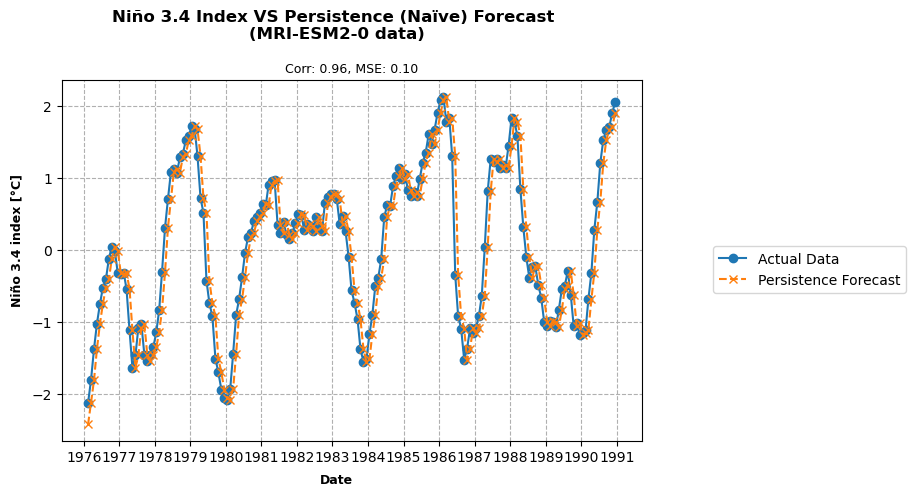

,nino34,Naïve Forecast,Forecast Error
time,,,
1976-02-15,-2.12,-2.42,0.30
1976-03-16,-1.81,-2.12,0.31
1976-04-16,-1.37,-1.81,0.43
1976-05-16,-1.02,-1.37,0.35
1976-06-16,-0.75,-1.02,0.28
1976-07-16,-0.52,-0.75,0.23
1976-08-16,-0.41,-0.52,0.11
1976-09-16,-0.12,-0.41,0.29
1976-10-16,0.05,-0.12,0.16


In [14]:
fig, ax = plt.subplots()

# compute Pearseon correlation coef and MSE
corr, _ = scipy.stats.pearsonr(df["Naïve Forecast"], df[target])
mse = mean_squared_error(df[target], df["Naïve Forecast"])

# Plot Naive predictions and actual values on the same plot
ax.plot(df[target], label=f'Actual Data', marker='o')
ax.plot(df["Naïve Forecast"], label="Persistence Forecast", linestyle='--', marker='x')

ax.set_title(f"Corr: {corr:.2f}, MSE: {mse:.2f}", fontsize=9)
ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.tick_params(axis='x', which='both', labelbottom=True) # Ensure the x-axis labels are visible for each subplot
ax.grid(linestyle='dashed')
handles, labels = ax.get_legend_handles_labels()
    
fig.legend(handles, labels, loc='upper right',  bbox_to_anchor=(1.4, 0.5))
# fig.legend(handles, labels, loc='upper right')
fig.suptitle(f'Niño 3.4 Index VS Persistence (Naïve) Forecast \n({source_id} data)', fontweight="bold")
fig.text(0.5, 0.0, 'Date', ha='center', va='center', fontsize=9, fontweight="bold")
fig.text(0.00, 0.5,  'Niño 3.4 index [°C]', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
plt.tight_layout(h_pad=2, w_pad=None, rect=None)
plt.show()
df.head(12)

### Horizon Forecasting

#### Load data

In [15]:
source_id = "MRI-ESM2-0"
# source_id = "MIROC6"
# source_id = "BCC-ESM1"
# source_id = "GISS-E2-1-G"

target = "nino34"

In [16]:
# val_start_date = '1976-01-01'
# val_end_date =   '1990-12-31'

val_start_date = '1995-01-01'
val_end_date =   '2010-12-31'

print(f"Val start and end dates: {val_start_date} to {val_end_date}")

Val start and end dates: 1995-01-01 to 2010-12-31


In [17]:
# extract year part of the dates
val_start_year = val_start_date.split("-")[0]
val_end_year   = val_end_date.split("-")[0]

print(f"Val start and end years: {val_start_year}-{val_end_year}")


Val start and end years: 1995-2010


In [18]:
ts = load_target_timeseries(source_id=source_id, target=target, start_date=val_start_date, end_date=val_end_date, verbose=True)
ts


• Search for `MRI-ESM2-0` target file in datasets/CMIP6/CMIP6_regridded/nino34
• Load CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt (1850-01-16 to 2014-12-16)
• Slice the time period from 1995-01-01 to 2010-12-31
• The dimensions are: (192,): 192 months, 1 target value per month



time
1995-01-16    1.84
1995-02-15    1.64
1995-03-16    1.46
1995-04-16    1.40
1995-05-16    0.90
              ... 
2010-08-16   -0.67
2010-09-16   -1.23
2010-10-16   -1.80
2010-11-16   -1.95
2010-12-16   -2.12
Name: nino34, Length: 192, dtype: float32

In [19]:
# convert time series to dataframe
df = ts.to_frame()

max_time_steps = 48
for lead_time in range(1, max_time_steps+1, 1): 
    col = "t"+str(lead_time)
    df[col] = df[target].shift(lead_time)
df.head(19)

,nino34,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48
time,,,,,,,,,,,,,,,,,,,,,
1995-01-16,1.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-15,1.64,1.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-16,1.46,1.64,1.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-16,1.40,1.46,1.64,1.84,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-16,0.90,1.40,1.46,1.64,1.84,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-16,0.01,0.90,1.40,1.46,1.64,1.84,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-16,-0.58,0.01,0.90,1.40,1.46,1.64,1.84,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-08-16,-0.44,-0.58,0.01,0.90,1.40,1.46,1.64,1.84,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-16,-0.38,-0.44,-0.58,0.01,0.90,1.40,1.46,1.64,1.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# drop rows containing missing values
df = df.dropna(axis=0)
df.head()

,nino34,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48
time,,,,,,,,,,,,,,,,,,,,,
1999-01-16,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,1.81,1.93,2.01,...,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40,1.46,1.64,1.84
1999-02-15,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,1.81,1.93,...,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40,1.46,1.64
1999-03-16,-0.99,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,1.81,...,-1.21,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40,1.46
1999-04-16,-0.89,-0.99,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,...,-1.37,-1.21,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40
1999-05-16,-0.89,-0.89,-0.99,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,...,-1.46,-1.37,-1.21,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90


In [21]:
valid_start_year = df.index[0].date().year
valid_end_year = df.index[-1].date().year

print(f"Val start and end years after dropping NaNs: {valid_start_year}-{valid_end_year}")

Val start and end years after dropping NaNs: 1999-2010


Saved plot_nino34_persistence_timeseries_MRI-ESM2-0_1995-2010.jpg to disk


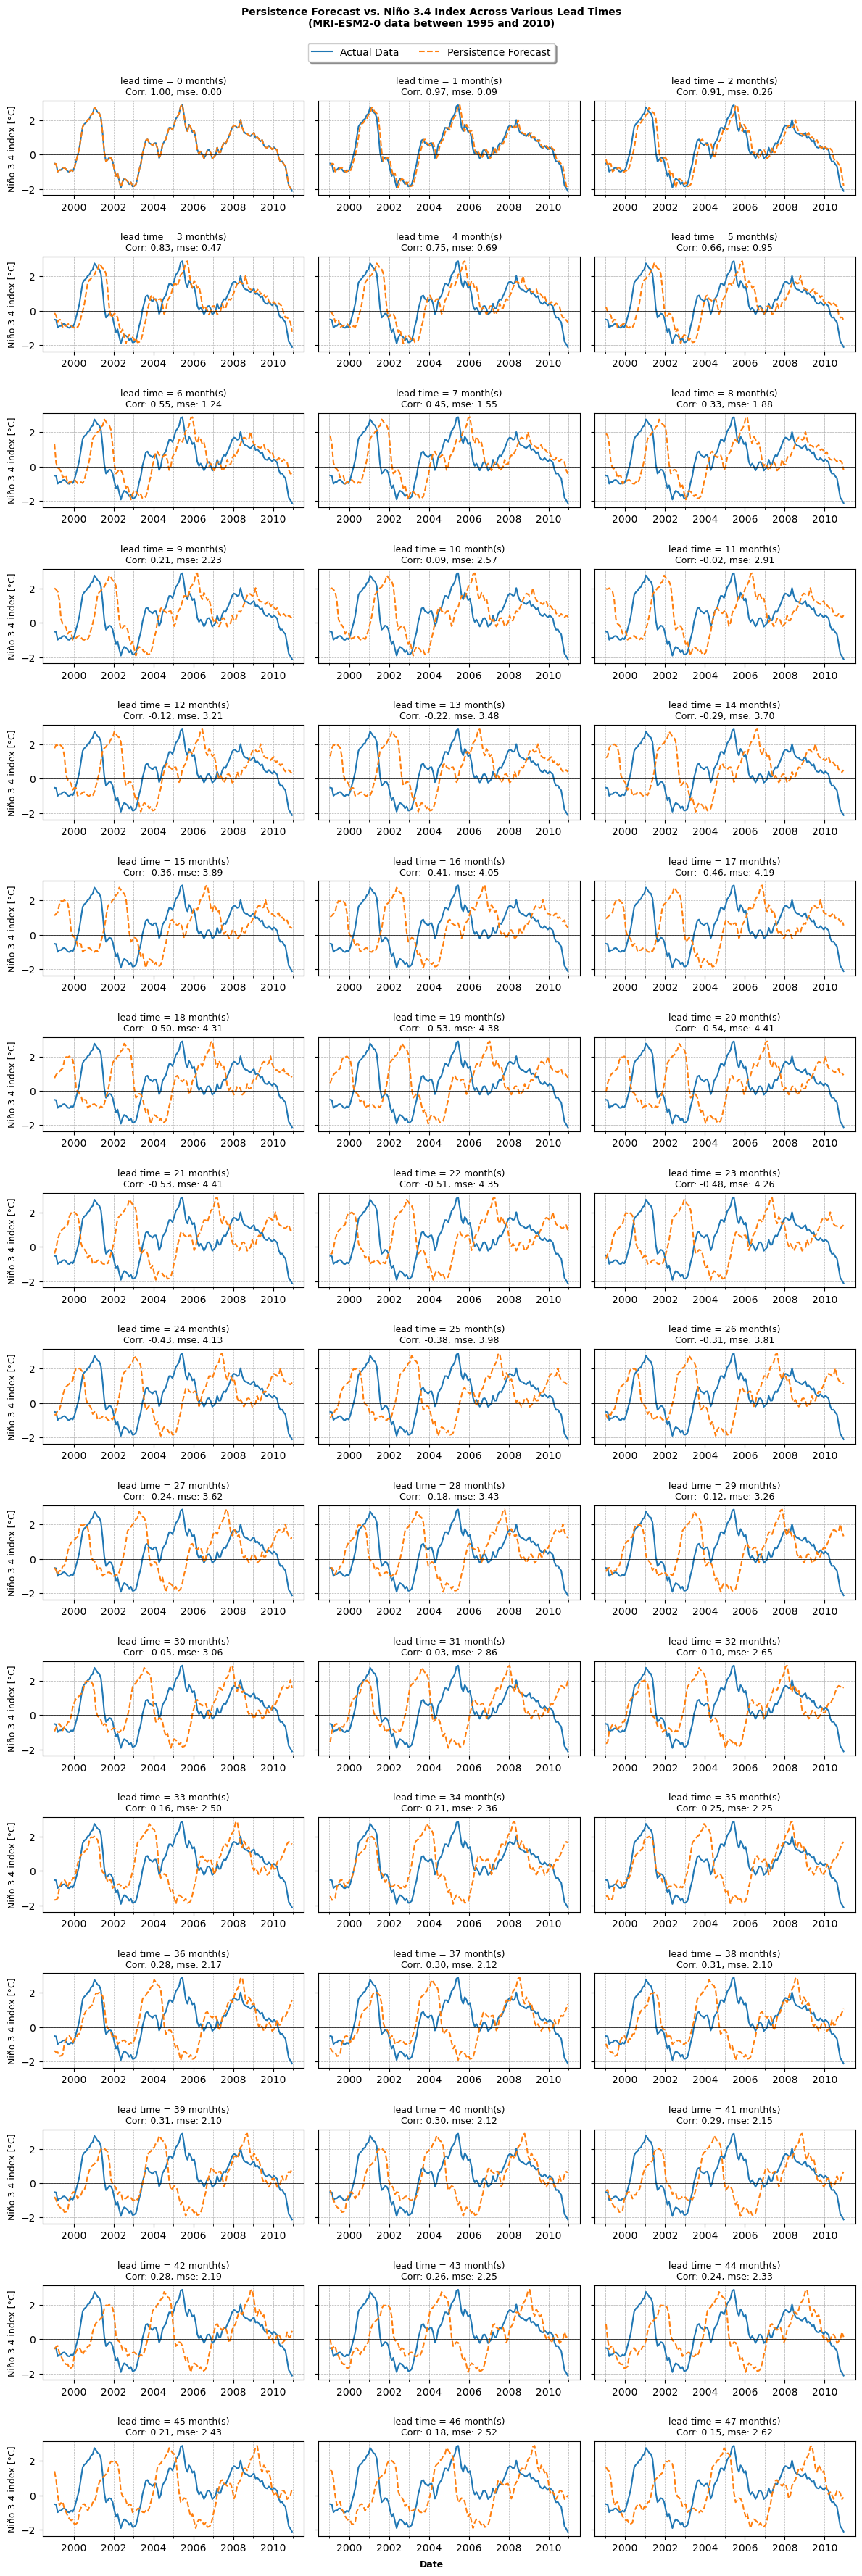

In [22]:
fig, axs = plt.subplots(nrows=int(max_time_steps/3), ncols=3, figsize=(12, 36), sharex=True, sharey=True)

y_val = df[target]
correlations = []
mses = []

# Iterate over the different timestep predictions and their respective axes
for i, (col, ax) in enumerate(zip(df.columns, axs.flat)):

    predictions = df[col]
    
    # Evaluate the model on the validation data
    corr, _ = scipy.stats.pearsonr(predictions, y_val)
    mse = mean_squared_error(y_val, predictions)

    correlations.append(corr)
    mses.append(mse)
    
    
    # Plot Naive predictions and actual values on the same plot
    ax.plot(y_val, label=f'Actual Data')
    ax.plot(predictions, label="Persistence Forecast", linestyle='--')

    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # base=2 for every other year    
    ax.xaxis.set_minor_locator(mdates.YearLocator(1))

    ax.set_title(f"lead time = {i} month(s)\nCorr: {corr:.2f}, mse: {mse:.2f}", fontsize=9)
    ax.tick_params(axis='x', which='both', labelbottom=True) # ensure the x-axis labels are visible for each subplot

    # ax.grid(linestyle='dashed')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set the y-label for the leftmost subplot in each row
    if i % 3 == 0:
        ax.set_ylabel('Niño 3.4 index [°C]', fontsize=9)
        
    handles, labels = ax.get_legend_handles_labels()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.968), ncol=2, shadow=True)

fig.suptitle(f'Persistence Forecast vs. Niño 3.4 Index Across Various Lead Times\n({source_id} data between {val_start_year} and {val_end_year})', fontweight="bold", fontsize=10)
fig.text(0.5, 0.0, 'Date', ha='center', va='center', fontsize=9, fontweight="bold")
# fig.text(0.00, 0.5,  'Niño 3.4 index (°C)', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
fig.tight_layout(h_pad=2, w_pad=None, rect=[0, 0, 1, 0.97]) # (left, bottom, right, top), default: (0, 0, 1, 1)


if SAVE_PLOTS_TO_DISK == True:
    filename = "plot_nino34_persistence_timeseries_"+source_id+"_"+val_start_year+"-"+val_end_year+".jpg"
    fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
    print(f"Saved {filename} to disk")
    
plt.show()

#### Plot Correlation coef. for various lead times

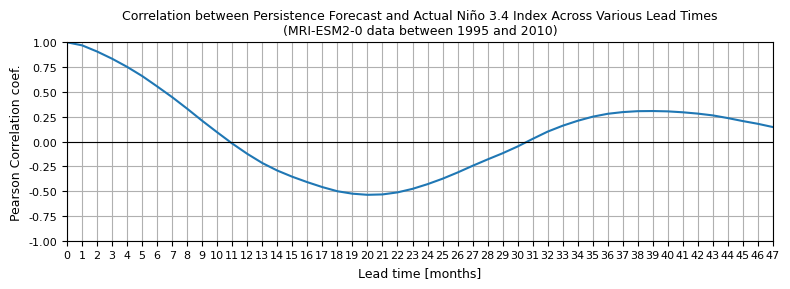

In [23]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(range(0,max_time_steps), correlations)
ax.set_ylabel('Pearson Correlation coef.', fontsize=9)
ax.set_ylim(-1,1)
ax.set_title(f'Correlation between Persistence Forecast and Actual Niño 3.4 Index Across Various Lead Times\n({source_id} data between {val_start_year} and {val_end_year})',
             fontweight="normal", fontsize=9)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('Lead time [months]', fontsize=9)
ax.set_xticks(range(0,max_time_steps))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.margins(x=0)

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.grid()
fig.tight_layout()
plt.show()

#### Plot MSE coef. for various lead times

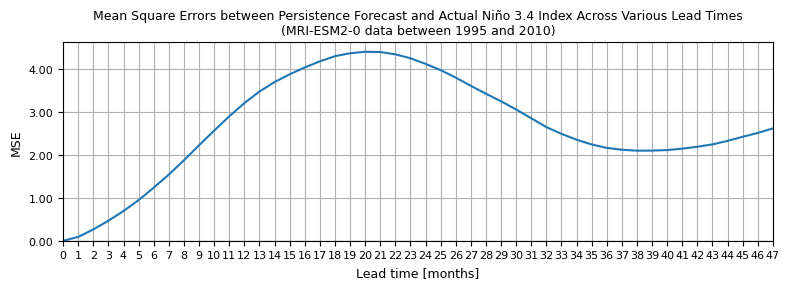

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(range(0,max_time_steps), mses)
ax.set_ylabel('MSE', fontsize=9)
ax.set_ylim(0,None)
ax.set_title(f'Mean Square Errors between Persistence Forecast and Actual Niño 3.4 Index Across Various Lead Times\n({source_id} data between {val_start_year} and {val_end_year})', 
             fontweight="normal", fontsize=9)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('Lead time [months]', fontsize=9)
ax.set_xticks(range(0,max_time_steps))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.margins(x=0)


plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.grid()
fig.tight_layout()
plt.show()

Saved plot_nino34_persistence_corr_mse_MRI-ESM2-0_1995-2010.jpg to disk


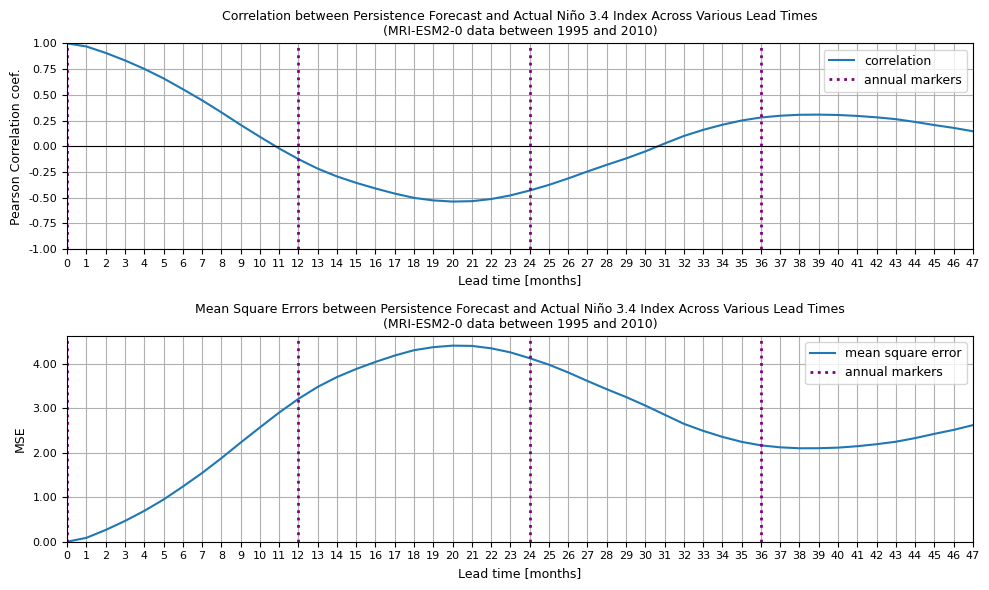

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

for i, ax in enumerate(axs.flat):
    if i == 0:
        ax.plot(range(0,max_time_steps), correlations, label="correlation")        
        ax.set_ylabel('Pearson Correlation coef.', fontsize=9)
        ax.set_ylim(-1,1)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax.set_title(f'Correlation between Persistence Forecast and Actual Niño 3.4 Index Across Various Lead Times\n({source_id} data between {val_start_year} and {val_end_year})',
                     fontweight="normal", fontsize=9)

    if i == 1:
        ax.plot(range(0,max_time_steps), mses, label="mean square error")
        ax.set_ylabel('MSE', fontsize=9)
        ax.set_ylim(0,None)
        ax.set_title(f'Mean Square Errors between Persistence Forecast and Actual Niño 3.4 Index Across Various Lead Times\n({source_id} data between {val_start_year} and {val_end_year})', 
                     fontweight="normal", fontsize=9)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Lead time [months]', fontsize=9)
    ax.set_xticks(range(0,max_time_steps))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.margins(x=0)
    ax.grid()
    # plot yearly vertical bar
    for x in range(0, max_time_steps, 12):
        if x == 0:
            ax.axvline(x, color='purple', linestyle='dotted', linewidth=2, label='annual markers')
        else:
            ax.axvline(x, color='purple', linestyle='dotted', linewidth=2)
    ax.legend(fontsize=9)

fig.tight_layout()

if SAVE_PLOTS_TO_DISK == True:
    filename = "plot_nino34_persistence_corr_mse_"+source_id+"_"+val_start_year+"-"+val_end_year+".jpg"
    fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
    print(f"Saved {filename} to disk")
plt.show()

# Autocorrelation Model

### ACF and PACF: Deciphering Dependencies:

- ACF measures the correlation between a time series and its past values at various lags, while 
- PACF takes into account the direct relationships, excluding indirect influences. (source: https://medium.com/@venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1)

Statsmodel doc:
- `sm.graphics.tsa.plot_acf`: Plot the autocorrelation function. Plots lags on the horizontal and the correlations on vertical axis.
- `sm.graphics.tsa.plot_pacf`: Plot the partial autocorrelation function.

In [26]:
ts = load_target_timeseries(source_id=source_id, target=target, start_date=val_start_date, end_date=val_end_date, verbose=True)
ts


• Search for `MRI-ESM2-0` target file in datasets/CMIP6/CMIP6_regridded/nino34
• Load CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt (1850-01-16 to 2014-12-16)
• Slice the time period from 1995-01-01 to 2010-12-31
• The dimensions are: (192,): 192 months, 1 target value per month



time
1995-01-16    1.84
1995-02-15    1.64
1995-03-16    1.46
1995-04-16    1.40
1995-05-16    0.90
              ... 
2010-08-16   -0.67
2010-09-16   -1.23
2010-10-16   -1.80
2010-11-16   -1.95
2010-12-16   -2.12
Name: nino34, Length: 192, dtype: float32

In [27]:
# extract year part of the dates
start_year = ts.index[0].date().year
end_year   = ts.index[-1].date().year

print(f"start and end years: {start_year}-{end_year}")

start and end years: 1995-2010


### Plot ACF and PACF using statsmodel plot functions

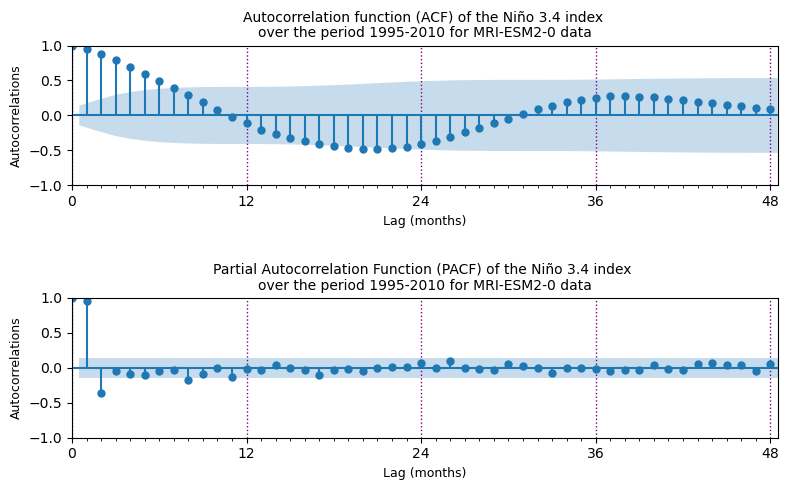

In [28]:
max_lags = 48
# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

# Plot ACF
sm.graphics.tsa.plot_acf(ts, lags=max_lags, ax=ax1, alpha=.05)
ax1.set_title(f'Autocorrelation function (ACF) of the Niño 3.4 index \nover the period {start_year}-{end_year} for {source_id} data', fontsize=10)
ax1.set_xlabel('Lag (months)', fontsize=9)
ax1.set_ylabel('Autocorrelations', fontsize=9)
ax1.xaxis.set_major_locator(MultipleLocator(12))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.margins(x=0)
ax1.xaxis.grid(True, which='major', color='purple', linestyle='dotted', linewidth=1)


# Plot PACF
sm.graphics.tsa.plot_pacf(ts, lags=max_lags, ax=ax2, alpha=.05)
ax2.set_title(f'Partial Autocorrelation Function (PACF) of the Niño 3.4 index \nover the period {start_year}-{end_year} for {source_id} data', fontsize=10)
ax2.set_xlabel('Lag (months)', fontsize=9)
ax2.set_ylabel('Autocorrelations', fontsize=9)
ax2.xaxis.set_major_locator(MultipleLocator(12))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.margins(x=0)
ax2.xaxis.grid(True, which='major', color='purple', linestyle='dotted', linewidth=1)

plt.tight_layout(h_pad=2.5)
plt.show()

### Plot ACF and PACF manually

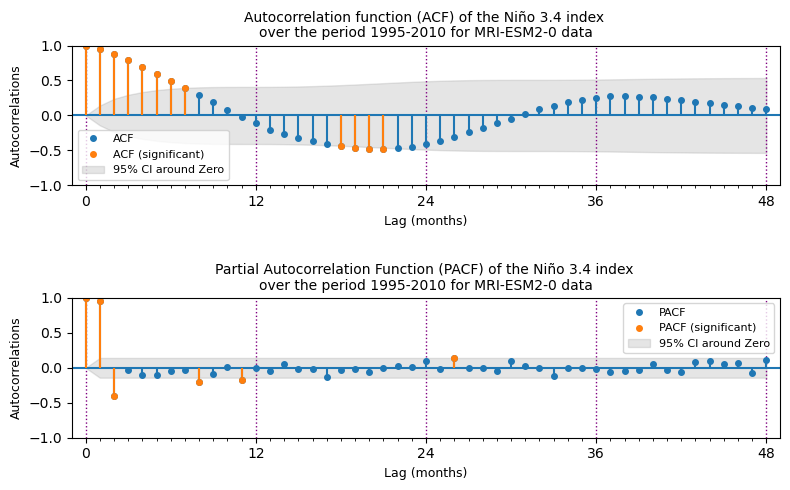

Significant lags for ACF:  [ 0  1  2  3  4  5  6  7 18 19 20 21]
Significant lags for PACF: [ 0  1  2  8 11 26]


In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

##### ACF ####
# Calculate the autocorrelation function and confidence intervals
acf, confint_acf = sm.tsa.acf(ts, alpha=0.05, nlags=max_lags, bartlett_confint=True)

# Identify significant lags (where ACF is outside the confidence bounds)
significant_lags_acf = np.where((acf < confint_acf[:, 0] - acf) | (acf > confint_acf[:, 1] - acf))[0]

# Plotting the ACF values
lags = np.arange(len(acf))
ax1.axhline(0)

ax1.vlines(lags, [0], acf)
ax1.vlines(significant_lags_acf, [0], acf[significant_lags_acf], color='tab:orange')

ax1.plot(lags, acf,  marker="o", markersize=4, linestyle="None", label='ACF')
ax1.plot(significant_lags_acf, acf[significant_lags_acf],  marker="o", markersize=4, linestyle="None", label='ACF (significant)')

# Plotting the confidence intervals
ax1.fill_between(lags, confint_acf[:, 0] - acf, confint_acf[:, 1] - acf, color='grey', alpha=0.2, label='95% CI around Zero')
ax1.set_ylim(-1,1)

# Adding legend and labels
ax1.legend(fontsize=8)
ax1.set_xlabel('Lag (months)', fontsize=9)
ax1.set_ylabel('Autocorrelations', fontsize=9)
ax1.set_title(f'Autocorrelation function (ACF) of the Niño 3.4 index \nover the period {start_year}-{end_year} for {source_id} data', fontsize=10)
ax1.xaxis.set_major_locator(MultipleLocator(12))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.grid(True, which='major', color='purple', linestyle='dotted', linewidth=1)
ax1.margins(x=0.02)



##### PACF ####
pacf, confint_pacf = sm.tsa.pacf(ts, nlags=max_lags, alpha=.05)

# Identify significant lags (where PACF is outside the confidence bounds)
significant_lags_pacf = np.where((pacf < confint_pacf[:, 0] - pacf) | (pacf > confint_pacf[:, 1] - pacf))[0]

# Plotting the PACF values
lags = np.arange(len(acf))
ax2.axhline(0)

ax2.vlines(lags, [0], pacf)
ax2.vlines(significant_lags_pacf, [0], pacf[significant_lags_pacf], color='tab:orange')

ax2.plot(lags, pacf,  marker="o", markersize=4, linestyle="None", label='PACF')
ax2.plot(significant_lags_pacf, pacf[significant_lags_pacf],  marker="o", markersize=4, linestyle="None", label='PACF (significant)')

# Plotting the confidence intervals
ax2.fill_between(lags, confint_pacf[:, 0] - pacf, confint_pacf[:, 1] - pacf, color='grey', alpha=0.2, label='95% CI around Zero')
ax2.set_ylim(-1,1)

# Adding legend and labels
ax2.legend(fontsize=8)
ax2.set_title(f'Partial Autocorrelation Function (PACF) of the Niño 3.4 index \nover the period {start_year}-{end_year} for {source_id} data', fontsize=10)
ax2.set_xlabel('Lag (months)', fontsize=9)
ax2.set_ylabel('Autocorrelations', fontsize=9)
ax2.xaxis.set_major_locator(MultipleLocator(12))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.xaxis.grid(True, which='major', color='purple', linestyle='dotted', linewidth=1)
ax2.margins(x=0.02)


plt.tight_layout(h_pad=2.5)
plt.show()

print("Significant lags for ACF: ", significant_lags_acf)
print("Significant lags for PACF:", significant_lags_pacf)


### Train a model using these features only

Correlation Feature Selection

So a good model might be:

$$\text{Nino3.4}_t = \beta_0 + \beta_1 \times \text{Nino3.4}_{t-1} + \beta_2 \times \text{Nino3.4}_{t-2} + \beta_8 \times \text{Nino3.4}_{t-8} + \beta_{11} \times \text{Nino3.4}_{t-11} + \beta_{26} \times \text{Nino3.4}_{t-26} + \epsilon_t $$


In [30]:
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [31]:
def select_features(df):
    # retain only the significant lags, except the 1st one (0th lag)
    return df.iloc[:,significant_lags_pacf[1:]]

select_features(df)

,t1,t2,t8,t11,t26
time,,,,,
1999-01-16,-0.65,-0.29,1.93,1.97,-0.66
1999-02-15,-0.52,-0.65,1.81,1.95,-0.90
1999-03-16,-0.54,-0.52,1.31,2.01,-0.68
1999-04-16,-0.99,-0.54,0.22,1.93,-0.69
1999-05-16,-0.89,-0.99,-0.07,1.81,-0.41
...,...,...,...,...,...
2010-08-16,-0.55,-0.39,0.30,0.39,1.57
2010-09-16,-0.67,-0.55,0.43,0.51,1.32
2010-10-16,-1.23,-0.67,0.34,0.40,1.23


In [32]:
ts = load_target_timeseries(source_id=source_id, target=target, start_date=train_start_date, end_date=train_end_date, verbose=True)
ts

# convert time series to dataframe
df_train = ts.to_frame()

max_time_steps = 48
for lead_time in range(1, max_time_steps+1, 1): 
    col = "t"+str(lead_time)
    df_train[col] = df_train[target].shift(lead_time)
df_train.head(19)

# drop rows containing missing values
df_train = df_train.dropna(axis=0)
df_train.head()


• Search for `MRI-ESM2-0` target file in datasets/CMIP6/CMIP6_regridded/nino34
• Load CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt (1850-01-16 to 2014-12-16)
• Slice the time period from 1851-01-01 to 1970-12-31
• The dimensions are: (1440,): 1440 months, 1 target value per month



,nino34,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48
time,,,,,,,,,,,,,,,,,,,,,
1855-01-16,0.44,0.16,0.23,0.19,0.22,0.42,0.43,-0.03,-0.59,-0.98,...,-0.67,-0.73,-0.47,-0.08,0.31,0.85,0.81,0.85,0.60,0.25
1855-02-15,0.76,0.44,0.16,0.23,0.19,0.22,0.42,0.43,-0.03,-0.59,...,-0.65,-0.67,-0.73,-0.47,-0.08,0.31,0.85,0.81,0.85,0.60
1855-03-16,1.19,0.76,0.44,0.16,0.23,0.19,0.22,0.42,0.43,-0.03,...,-0.65,-0.65,-0.67,-0.73,-0.47,-0.08,0.31,0.85,0.81,0.85
1855-04-16,1.67,1.19,0.76,0.44,0.16,0.23,0.19,0.22,0.42,0.43,...,-0.40,-0.65,-0.65,-0.67,-0.73,-0.47,-0.08,0.31,0.85,0.81
1855-05-16,1.91,1.67,1.19,0.76,0.44,0.16,0.23,0.19,0.22,0.42,...,-0.21,-0.40,-0.65,-0.65,-0.67,-0.73,-0.47,-0.08,0.31,0.85


In [33]:
X_train_df = select_features(df_train)
y_train_df = df_train.iloc[:, 0]

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

In [34]:
ts_val = load_target_timeseries(source_id=source_id, target=target, start_date=val_start_date, end_date=val_end_date, verbose=True)
ts_val.head()

# convert time series to dataframe
df_val = ts_val.to_frame()

max_time_steps = 48
for lead_time in range(1, max_time_steps+1, 1): 
    col = "t"+str(lead_time)
    df_val[col] = df_val[target].shift(lead_time)
df_val.head(19)

# drop rows containing missing values
df_val = df_val.dropna(axis=0)
df_val.head()


• Search for `MRI-ESM2-0` target file in datasets/CMIP6/CMIP6_regridded/nino34
• Load CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt (1850-01-16 to 2014-12-16)
• Slice the time period from 1995-01-01 to 2010-12-31
• The dimensions are: (192,): 192 months, 1 target value per month



,nino34,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48
time,,,,,,,,,,,,,,,,,,,,,
1999-01-16,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,1.81,1.93,2.01,...,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40,1.46,1.64,1.84
1999-02-15,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,1.81,1.93,...,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40,1.46,1.64
1999-03-16,-0.99,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,1.81,...,-1.21,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40,1.46
1999-04-16,-0.89,-0.99,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,1.31,...,-1.37,-1.21,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90,1.40
1999-05-16,-0.89,-0.89,-0.99,-0.54,-0.52,-0.65,-0.29,-0.14,-0.07,0.22,...,-1.46,-1.37,-1.21,-0.97,-0.80,-0.38,-0.44,-0.58,0.01,0.90


In [35]:
X_val_df = select_features(df_val)
y_val_df = df_val.iloc[:, 0]

X_val = X_val_df.to_numpy()
y_val = y_val_df.to_numpy()
X_val.shape, y_val.shape

((144, 5), (144,))

#### Plot results

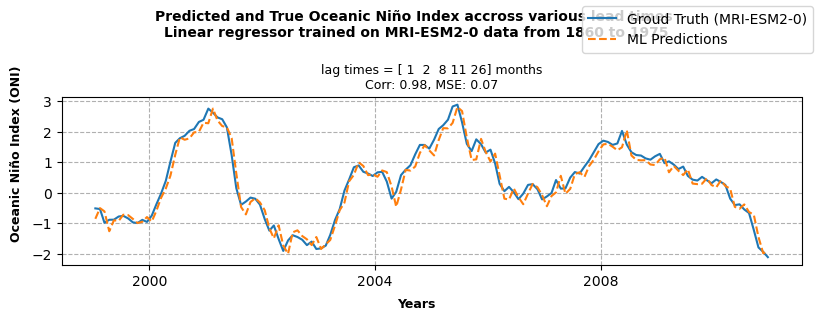

In [36]:
# Train a Linear regression model using the training data
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

# Evaluate the model on the validation data
predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
mse = mean_squared_error(y_val, predictions)

fig, ax = plt.subplots(figsize=(8, 3))


# Align timestamps of predictions and actual values
predictions = pd.Series(predictions, index=y_val_df.index)
predictions = predictions.sort_index()
y_val = y_val_df.sort_index()

# Plot machine learning predictions and actual values on the same plot
ax.plot(y_val, label=f'Groud Truth ({source_id})')
ax.plot(predictions, '--', label='ML Predictions')

ax.set_title(f"lag times = {significant_lags_pacf[1:]} months\nCorr: {corr:.2f}, MSE: {mse:.2f}", fontsize=9)
ax.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
ax.tick_params(axis='x', which='both', labelbottom=True) # ensure the x-axis labels are visible for each subplot
ax.grid(linestyle='dashed')
handles, labels = ax.get_legend_handles_labels()
    
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f'Predicted and True Oceanic Niño Index accross various lead times \nLinear regressor trained on {source_id} data from 1860 to 1975', fontsize=10, fontweight="bold")
fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight="bold")
fig.text(0.00, 0.5,  'Oceanic Niño Index (ONI)', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
plt.tight_layout( h_pad=2, w_pad=None, rect=None)
plt.show()